In [1]:
%load_ext autoreload
%autoreload 2
import os
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torch.nn.functional as F 
from torch import autograd
from torch import optim
from torch.autograd import Variable
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import torchvision
from torchvision.utils import save_image
import torch.backends.cudnn as cudnn
import torch.nn as nn
import json
import util
from tqdm import tqdm_notebook
from models import *

cudnn.benchmark = True
from advertorch.attacks import LinfPGDAttack, L2PGDAttack
from advertorch.utils import NormalizeByChannelMeanStd

In [2]:
MEAN = torch.Tensor([0.4914, 0.4822, 0.4465])
STD = torch.Tensor([0.2023, 0.1994, 0.2010])


def unnormalize(im):
    mean = MEAN.cuda() if im.is_cuda else MEAN
    std = STD.cuda() if im.is_cuda else STD

    if im.dim() == 4:
        im = im.transpose(1, 3)
        im = im * std + mean
        im = im.transpose(1, 3)
    else:
        im = im.transpose(0, 2)
        im = im * std + mean
        im = im.transpose(0, 2)

    return im


def normalize(im):
    mean = MEAN.cuda() if im.is_cuda else MEAN
    std = STD.cuda() if im.is_cuda else STD

    if im.dim() == 4:
        im = im.transpose(1, 3)
        im = (im - mean) / std
        im = im.transpose(1, 3)
    else:
        im = im.transpose(0, 2)
        im = (im - mean) / std
        im = im.transpose(0, 2)

    return im

def BIM(image, classifier, target, max_eps, itr_eps=1 / 255, itr=20):
    eps = torch.zeros_like(image).cuda()
    for _ in range(itr):
        eps.requires_grad = True
        with torch.enable_grad():
            output = classifier(normalize((image+eps).clamp(0,1)))
            loss = F.cross_entropy(
                output, target, size_average=False
            )
        grad = torch.autograd.grad(loss, [eps])[0]
        eps = eps + itr_eps * torch.sign(grad.detach())
        eps = eps.clamp(-max_eps, max_eps).detach()
    return eps

transform = transforms.Compose([
    transforms.ToTensor(),
])


criterion = nn.CrossEntropyLoss()
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# criterion = nn.MSELoss()


classifier = torch.nn.DataParallel(ResNet18()).cuda().eval()
classifier_feat = torch.nn.DataParallel(ResNet18_feat()).cuda().eval()

# checkpoint = torch.load('./checkpoint/ckpt.t7')
checkpoint = torch.load('./checkpoint/ckpt_accumulate_10_scale1_warm1.t7')
classifier.load_state_dict(checkpoint['net'])
classifier_feat.load_state_dict(checkpoint['net'])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# trainset = torchvision.datasets.ImageFolder(root='./robust_data', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

out_dir = './robust_data_madry'
util.create_dirs(out_dir)
for i in range(10):
    util.create_dirs(os.path.join(out_dir, str(i)))

max_eps = 8/255

norm = NormalizeByChannelMeanStd(
    mean=MEAN, std=STD)

adv_model = nn.Sequential(norm, classifier).cuda()

# adversary = LinfPGDAttack(
#     adv_model, eps=8. / 255, eps_iter=1 / 255, nb_iter=10,
#     rand_init=True, targeted=False)
adversary = L2PGDAttack(
    adv_model, eps=0.5, eps_iter=0.5/5, nb_iter=10,
    rand_init=True, targeted=False)

Files already downloaded and verified


In [5]:
def new_robustify(im, target, iterations, classifier):
    with torch.no_grad():
        target_feat, _ = classifier_feat(normalize(im))

    for j in tqdm_notebook(range(iterations)):
        im.requires_grad_()
        total_loss = 0

        eps = (adversary.perturb(im, target) - im).detach()
        output = classifier(normalize((im + eps).clamp(0, 1)))
        xe_loss =criterion(output, target) 
        
        output_feat, _ = classifier_feat(normalize((im).clamp(0, 1)))
#         feat_loss = 1e-2 * F.mse_loss(output_feat[-1], target_feat[-1])
        
#         print(j, xe_loss.item())#, feat_loss.item())
        total_loss = total_loss + xe_loss# + feat_loss
        if xe_loss < 1e-4:
            return im.clamp(0,1)
        
#         resized_loss = 0
#         for i in range(5):
#             factor = np.random.uniform(1.2, 0.8)
#             resized_im = F.interpolate(
#                 ((im)).clamp(0, 1), scale_factor=factor, mode="nearest"
#             )
#             output = classifier(normalize((resized_im)))
#             resized_loss += criterion(output, target)# 
#         total_loss += resized_loss
# #         print(j, loss.item(), resized_loss.item())
#         if total_loss.item() < 1e-4:
#             return im.clamp(0,1)

        total_loss.backward()
        im = (im - 0.5/255*im.grad.data.sign()).clamp(0,1).detach()
#         im = (im - 0.1*im.grad.data/im.grad.data.norm(2, dim=(1,2,3))[:,None,None,None]).clamp(0,1).detach()

    out = (im).clamp(0, 1)
    return out

def madry_robustify(im, iterations=1000):
    index = torch.randperm(im.size(0)).cuda()
    shuffled_im = im[index] 
    with torch.no_grad():
        target_feat, _ = classifier_feat(normalize(im))
    
    for i in tqdm_notebook(range(iterations)):
        shuffled_im.requires_grad_()
        output_feat, _ = classifier_feat(normalize(shuffled_im))
        loss = F.mse_loss(output_feat[-1], target_feat[-1])
        loss.backward()
        shuffled_im = (shuffled_im - 0.1*shuffled_im.grad.data/shuffled_im.grad.data.norm(2, dim=(1,2,3))[:,None,None,None]).clamp(0,1).detach()
        
    return shuffled_im

In [ ]:
iterations = 100
count = [0] * 10
for batch_idx, (inputs, targets) in enumerate(tqdm_notebook(trainloader)):
    inputs = inputs.cuda()
    targets = targets.cuda()

    out = inputs
#     out = new_robustify(inputs, targets, iterations, classifier)
    out = madry_robustify(inputs)

    for i in range(inputs.size(0)):
        save_image(out[i], os.path.join(out_dir, str(targets[i].item()), '%d.png'%(count[int(targets[i])])))
        count[int(targets[i])] += 1

In [ ]:
for batch_idx, (inputs, targets) in enumerate(tqdm_notebook(trainloader)):
    continue

inputs = inputs.cuda()
targets = targets.cuda()
out = inputs.clone()
out_madry = inputs.clone()
out = new_robustify(out, targets, 100, classifier)
out_madry = madry_robustify(out)

In [286]:
# save_image(out, 'robust.png')
# adv = util.BIM(out.detach(), classifier, targets, 8/255, itr_eps=1 / 255, itr=20)
strong_adversary = L2PGDAttack(
    adv_model, eps=0.5, eps_iter=0.25/5, nb_iter=100,
    rand_init=True, targeted=False)

adv = strong_adversary.perturb(out.detach(), targets)
robust_label = classifier(normalize(out)).argmax(1)
adv_label = classifier(normalize(adv)).argmax(1)

print((targets==robust_label).sum().float()/ inputs.size(0))
print((targets==adv_label).sum().float()/inputs.size(0))

classifier_dense = torch.nn.DataParallel(DenseNet121()).cuda().eval()
checkpoint = torch.load('./checkpoint/ckpt_dense.t7')
classifier_dense.load_state_dict(checkpoint['net'])

dense_label = classifier_dense(normalize(out)).argmax(1)

print((targets==dense_label).sum().float()/ inputs.size(0))

tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(0.9875, device='cuda:0')


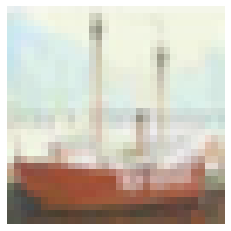

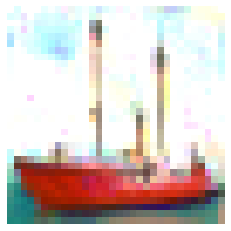

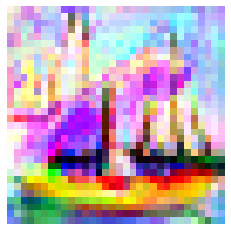

In [293]:
idx = 12
util.display_image(inputs[idx])
util.display_image(out[idx])
util.display_image(out_madry[idx])